# 과제#3. [평가] 이동통신 고객 이탈 예측

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 00 통신회사의 올해 고객 목표는, **현재 고객수를 유지**하는 것입니다.
* 더욱 치열해진 경쟁 상황에서 고객수를 유지하는 것은 굉장히 도전적인 목표 입니다.
* 이를 위해 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 에이블러 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 예측 모델링을 의뢰하였습니다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as spst

from sklearn.model_selection import train_test_split

### 2) 데이터 로딩

In [11]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
data = pd.read_csv(data_path)
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	OVER_15MINS_CALLS_PER_MONTH	|	 평균 장기통화(15분 이상) 횟수	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	REPORTED_USAGE_LEVEL	|	사용 수준 설문('very_little', 'little', 'avg', 'high', 'very_high') - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


----

## 1.데이터 탐색

## 2.데이터 전처리 

In [12]:
target = 'CHURN'

### 2.1 데이터 정리

* feature와 , target으로 분할

In [13]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 불필요한 feature 제거
    * 제거해야 할 feature를 선정하고 제거하시오. 제거 이유를 주석으로 기술합니다.

In [14]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           18000 non-null  int64  
 1   COLLEGE                      18000 non-null  int64  
 2   INCOME                       18000 non-null  int64  
 3   OVERAGE                      18000 non-null  int64  
 4   LEFTOVER                     18000 non-null  int64  
 5   HOUSE                        17785 non-null  float64
 6   HANDSET_PRICE                18000 non-null  int64  
 7   OVER_15MINS_CALLS_PER_MONTH  18000 non-null  int64  
 8   AVERAGE_CALL_DURATION        18000 non-null  int64  
 9   REPORTED_SATISFACTION        17962 non-null  object 
 10  REPORTED_USAGE_LEVEL         18000 non-null  object 
 11  CONSIDERING_CHANGE_OF_PLAN   18000 non-null  object 
dtypes: float64(1), int64(8), object(3)
memory usage: 1.6+ MB


In [15]:
var = 'CONSIDERING_CHANGE_OF_PLAN'

x['CONSIDERING'] = 'No'
x.loc[(x[var]=='perhaps'), 'CONSIDERING'] = 'Maybe'
x.loc[(x[var]=='actively_looking_into_it') | (x[var]=='considering'), 'CONSIDERING'] = 'Yes'
table = pd.crosstab(y, x['CONSIDERING'])
print('교차표\n', table)
print('-' * 50)
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('자유도:', result[2])

교차표
 CONSIDERING  Maybe    No   Yes
CHURN                         
0              456  2749  5926
1              502  2699  5668
--------------------------------------------------
카이제곱통계량 4.5963159723849465
p-value 0.10044369209162551
자유도: 2


In [16]:
var = 'REPORTED_SATISFACTION'

x['SATISFACTION'] = 'Unsat'
x.loc[(x[var]=='very_sat') | (x[var]=='sat'), 'SATISFACTION'] = 'Sat'
x.loc[(x[var]=='avg'), 'SATISFACTION'] = 'Avg'
table = pd.crosstab(y, x['SATISFACTION'])
print('교차표\n', table)
print('-' * 50)
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('자유도:', result[2])

교차표
 SATISFACTION  Avg   Sat  Unsat
CHURN                         
0             952  2826   5353
1             854  2668   5347
--------------------------------------------------
카이제곱통계량 6.052786792281953
p-value 0.048490208106138445
자유도: 2


In [18]:
# 딥러닝을 통해 새로운 feature를 만들 수 있기 때문에 모든 데이터를 지우지 않고 진행해 보겠습니다.
# id 값은 모두 고유 값으로 제거하겠습니다.

drop_cols=['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x.drop(drop_cols, axis=1, inplace=True)
x.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CONSIDERING,SATISFACTION
0,544,1,47711,183,17,730589.0,192,19,5,Yes,Unsat
1,689,0,74132,191,43,535092.0,349,15,2,No,Unsat
2,3134,1,150419,0,14,204004.0,682,0,6,Yes,Unsat
3,12523,0,159567,0,58,281969.0,634,1,1,No,Unsat
4,2374,1,23392,0,0,216707.0,233,0,15,No,Unsat


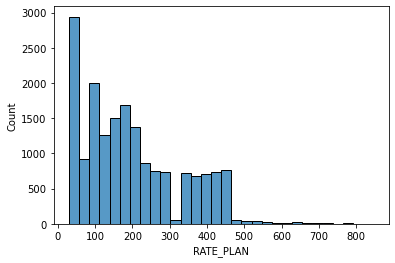

In [19]:
x['RATE_PLAN'] = (x['AVERAGE_CALL_DURATION'] * 30) * (1 + (x['LEFTOVER']) / 100)
sns.histplot(x['RATE_PLAN'], bins=30)
plt.show()

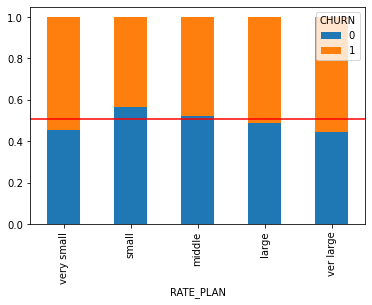

In [20]:
bin = [0,100,200,300,500,np.inf]
x['RATE_PLAN'] = pd.cut(x['RATE_PLAN'], bins=bin, labels=['very small', 'small', 'middle', 'large', 'ver large'])
table = pd.crosstab(x['RATE_PLAN'], data[target], normalize='index')
table.plot.bar(stacked=True)
plt.axhline(1-data[target].mean(), color='r')
plt.show()

In [21]:
table = pd.crosstab(data[target], x['RATE_PLAN'])
result = spst.chi2_contingency(table)
print('요금제')
print(table)
print('-' * 50)
print('카이제곱통계량', result[0])
print('p-value', result[1])

요금제
RATE_PLAN  very small  small  middle  large  ver large
CHURN                                                 
0                2286   3188    1751   1816         90
1                2764   2467    1604   1922        112
--------------------------------------------------
카이제곱통계량 145.23023592459856
p-value 2.1410261838465043e-30


In [22]:
x.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CONSIDERING,SATISFACTION,RATE_PLAN
0,544,1,47711,183,17,730589.0,192,19,5,Yes,Unsat,small
1,689,0,74132,191,43,535092.0,349,15,2,No,Unsat,very small
2,3134,1,150419,0,14,204004.0,682,0,6,Yes,Unsat,middle
3,12523,0,159567,0,58,281969.0,634,1,1,No,Unsat,very small
4,2374,1,23392,0,0,216707.0,233,0,15,No,Unsat,large


### 2.2 NaN에 대한 조치
* 데이터에 포함된 NaN에 대해서 조치 방법을 결정하고 적용합니다.
* **조치방법을 결정한 이유**를 주석으로 기술합니다.

In [ ]:
x.isna().sum()

In [ ]:
# KNNImpute를 사용하기 위해 가변수화를 진행하고 진행하겠습니다.
# KNNImpute를 사용하는 이유는 NaN 값이 있는 feature를 target으로 그 외의 값으로 예측을 하기 때문에 가장 정확할 것이라고 생각했습니다.

### 2.3 (옵션) 추가변수 도출
* 기존 데이터셋의 변수를 이용하여 추가로 도출할 수 있는 변수가 있다면 수행합니다.
* 추가변수 생성시, 이유에 대해서 **주석**으로 기술합니다.

### 2.4 가변수화
* 범주형 데이터이면서 값이 0,1 로 되어 있는 것이 아니라면, 가변수화를 수행해야 합니다.
* 대상이 되는 변수에 대해서 가변수화를 수행해주세요.

In [ ]:
dump_col = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns=dump_col)
x.head()

In [ ]:
# KNNImpute로 NaN 값을 처리하겠습니다.
from sklearn.impute import KNNImputer

impute = KNNImputer(n_neighbors=5)
imputed = impute.fit_transform(x)
x = pd.DataFrame(imputed, columns=x.columns)
x.head()

In [ ]:
x.isna().sum()

### 2.5 데이터 분할

* test 3000건(test_size = 3000), random_state = 2022
* val 3000건(test_size = 3000), random_state = 2022
* train 나머지.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=300, random_state=2022)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=300, random_state=2022)

In [ ]:
# train은 훈련용으로 사용, vla은 성능 확인용으로 사용, test는 선택된 모델의 최종 성능을 확인하기 위해 사용합니다.
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

### 2.6 (옵션)스케일링 
* 스케일링을 필요로 하는 알고리즘이 있습니다. 
* 필요하다고 판단될때 수행합니다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_col = list(x_train)

# MinMaxScaler 적용
x_tr_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)
x_te_s = scaler.transform(x_test)

# DataFrame으로 변환
x_tr_s = pd.DataFrame(x_tr_s, columns=x_col)
x_val_s = pd.DataFrame(x_val_s, columns=x_col)
x_te_s = pd.DataFrame(x_te_s, columns=x_col)

In [ ]:
x_tr_s.head()

## 3.모델링1 : 머신러닝

### 3.1 모델링을 위한 함수 불러오기

* **꼭 필요한 라이브러리 혹은 함수**만 불러옵니다. 무조건 다 불러오는 것은 지양해주세요.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

### 3.2 모델링
* 최소 3개 이상의 알고리즘을 선정합니다.(알고리즘에는 최소 1개 이상의 앙상블 기법을 포함)
    * 아래 주어진 목록 이외의 알고리즘을 선정해도 좋습니다.
* 각 알고리즘별 튜닝을 수행하여 최적의 모델을 생성합니다.
    * 튜닝 방식은 GridSearchCV, RandomizedSearchCV 혹은 for loop 로 직접
    * 단, 선형회귀, 로지스틱 회귀의는 입력 변수(feature)를 조절하여 튜닝을 합니다.
    * 튜닝 과정에 대해서 주석으로 기술합니다.
* 모델링, 튜닝만 수행하는데 그치지 말고, 모델의 내용을 파악하기 위한 분석을 시도합니다. 코드 결과에 대한 분석 의견을 주석으로 기술합니다.
    * 예 : 모델 시각화 및 내용 파악, 튜닝 결과 분석 및 시각화

#### (1) Logistic Regression

In [ ]:
model_lg = LogisticRegression()

In [ ]:
model_lg.fit(x_train, y_train)

In [ ]:
for i in range(len(list(x_train))) :
    print(list(x_train)[i], ':', model_lg.coef_[0][i])
    
print(model_lg.intercept_)

In [ ]:
# LogisticRegression의 변수 가중치는 이번 모델에 변수가 미치는 중요도라고 파악하여 시각화 진행
plt.figure(figsize=(15, 10))
plt.barh(width=model_lg.coef_[0], y=list(x_train))
plt.show()

In [ ]:
# 예측
lg_y_val_pred = model_lg.predict(x_val)
print(classification_report(y_val, lg_y_val_pred))

#### (2) KNN

- knn은 거리로 예측을 하는 알고리즘으로 scaler를 적용한 feature로 진행

In [ ]:
model_knn = KNeighborsClassifier()

param = {'n_neighbors' : range(2, 11)}

model_knn_grid = GridSearchCV(model_knn,
                              param,
                              cv=10,
                              scoring='accuracy')

In [ ]:
model_knn_grid.fit(x_tr_s, y_train)

In [ ]:
# 최적의 파라미터를 갖는 모델 확인
model_knn_grid.best_estimator_

In [ ]:
# 예측
knn_y_val_pred = model_knn_grid.predict(x_val_s)
print(classification_report(y_val, knn_y_val_pred))

#### (3) Decision Tree

In [ ]:
model_dt = DecisionTreeClassifier(random_state=2022)

param = {'max_depth' : range(2, 50)}

model_dt_random = RandomizedSearchCV(model_dt,
                                     param,
                                     cv=10,
                                     n_iter=20,
                                     scoring='accuracy')

model_dt_random.fit(x_train, y_train)
print(model_dt_random.best_estimator_)

In [ ]:
# RandomizedSearchCV 결과를 DataFrame으로 변환
result_random = pd.DataFrame(model_dt_random.cv_results_)
result_random = result_random[['param_max_depth', 'mean_test_score']]
result_random.sort_values(by='param_max_depth', inplace=True)
result_random.reset_index(drop=True, inplace=True)

In [ ]:
# GridSearchCV 할 범위 지정
idx = result_random[result_random['param_max_depth']==model_dt_random.best_params_['max_depth']].index[0]

start = 1
end = 51
if idx != 0 :
    start = result_random.loc[idx-1]['param_max_depth']
if idx != 10 :
    end = result_random.loc[idx+1]['param_max_depth']

In [ ]:
# GridSEarchCV 진행
param = {'max_depth' : range(start, end)}

model_dt_grid = GridSearchCV(model_dt,
                         param,
                         cv=10,
                         scoring='accuracy')

model_dt_grid.fit(x_train, y_train)

print(model_dt_grid.best_estimator_)

In [ ]:
# 시각화
from sklearn.tree import export_graphviz

export_graphviz(model_dt_grid.best_estimator_,
                out_file = 'tree.dot',
                feature_names = x_train.columns,
                rounded = True, precision = 3, filled = True)
!dot -Tpng tree.dot -o tree.png -Gdpi=300

#이미지 파일 로딩하기.
from IPython.display import Image
Image(filename = 'tree.png', width = 800)  # 사이즈 조정.

# 7일 전의 이용량과 2일전의 이용량 변수가 자주 사용되었음을 확인가능

In [ ]:
# 예측
dt_y_val_pred = model_dt_grid.predict(x_val)
print(classification_report(y_val, dt_y_val_pred))

#### (4) SVM
- svm은 거리로 예측을 하는 알고리즘으로 scaler를 적용한 feature로 진행

In [ ]:
# GridSearchCV로 끝날 기미가 보이지 않아 우선 parameter 없이 진행했습니다.

model_svm = SVC()

model_svm.fit(x_tr_s, y_train)

In [ ]:
# 예측
svm_y_val_pred = model_svm.predict(x_val_s)
print(classification_report(y_val, svm_y_val_pred))

#### (5) Random Forest

In [ ]:
# GridSearchCV로 끝날 기미가 보이지 않아 우선 parameter 없이 진행했습니다.

model_rf = RandomForestClassifier(random_state=2022)

model_rf.fit(x_train, y_train)

In [ ]:
plt.barh(y=list(x_train), width=model_rf.feature_importances_)
plt.show()

In [ ]:
# 예측
rf_y_val_pred = model_rf.predict(x_val)
print(classification_report(y_val, rf_y_val_pred))

#### (6) XGBoost

In [ ]:
# GridSearchCV로 끝날 기미가 보이지 않아 우선 parameter 없이 진행했습니다.

model_xgb = XGBClassifier()

model_xgb.fit(x_train, y_train)

In [ ]:
plt.barh(y=list(x_train), width=model_xgb.feature_importances_)
plt.show()

In [ ]:
xgb_y_val_pred = model_xgb.predict(x_val)
print(classification_report(y_val, xgb_y_val_pred))

## 4.모델링2 : DL

### 4.1 모델링을 위한 함수 불러오기

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Add, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

### 4.2 모델링

* 딥러닝 모델을 3개 이상 생성하시오
    * 다양한 구조의 모델 3개 이상을 설계하시오. (히든레이어, 노드 수 조절)
    * 각 모델은 구조가 달라야 합니다.
    * 구조를 그렇게 구성한 이유를 주석으로 기술해 봅시다.
* 각 모델마다 
    * 구조를 summary 혹은 plot model로 확인
    * 학습 후 history plot 그리고 적절하게 학습이 되었는지 확인    

#### (1) 모델1

In [ ]:
x_train.shape, y_train.shape

In [ ]:
# 가장 기본적인 input과 output만 있는 모델을 생성해봤습니다.

# 초기화
clear_session()

# 레이어 생성
input_layer = Input(shape=(23,))
output_layer = Dense(1, activation='sigmoid')(input_layer)

# 모델 생성
model_dl1 = Model(input_layer, output_layer)

# 컴파일
model_dl1.compile(loss=binary_crossentropy, metrics=['accuracy'], optimizer=Adam())

# summary
model_dl1.summary()

In [ ]:
plot_model(model_dl1, show_shapes=True)

In [ ]:
# 모델 훈련
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

history1 = model_dl1.fit(x_train, y_train, epochs=100, verbose=1, callbacks=[es], validation_split=0.15)

In [ ]:
# 모델 history plot
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')

plt.legend()

plt.show()

In [ ]:
# 모델 history plot
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')

plt.legend()

plt.show()

In [ ]:
# 예측
dl1_y_val_pred = model_dl1.predict(x_val)
dl1_y_val_pred = np.where(dl1_y_val_pred>0.5, 1, 0)
print(classification_report(y_val, dl1_y_val_pred))

#### (2) 모델2

In [ ]:
# hidden layer를 2개를 더 추가하여 새로운 feature를 생성하여 훈련을 시켜보겠습니다.

# 초기화
clear_session()

# 레이어 생성
input_layer = Input(shape=(23,))
hiden_layer = Dense(32, activation='relu')(input_layer)
hiden_layer = Dense(16, activation='relu')(hiden_layer)
output_layer = Dense(1, activation='sigmoid')(hiden_layer)

# 모델 생성
model_dl2 = Model(input_layer, output_layer)

# 컴파일
model_dl2.compile(loss=binary_crossentropy, metrics=['accuracy'], optimizer=Adam())

# summary
model_dl2.summary()


In [ ]:
plot_model(model_dl2, show_shapes=True)

In [ ]:
# 모델 훈련
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

history2 = model_dl2.fit(x_train, y_train, epochs=100, verbose=1, callbacks=[es], validation_split=0.15)

In [ ]:
# 모델 history plot
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')

plt.legend()

plt.show()

In [ ]:
# 모델 history plot
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')

plt.legend()

plt.show()

In [ ]:
# 예측
dl2_y_val_pred = model_dl2.predict(x_val)
dl2_y_val_pred = np.where(dl2_y_val_pred>0.5, 1, 0)
print(classification_report(y_val, dl2_y_val_pred))

#### (3) 모델3

In [ ]:
dic = {'satisfaction' : ['REPORTED_SATISFACTION_avg', 'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat', 'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat'],
       'usage' : ['REPORTED_USAGE_LEVEL_avg', 'REPORTED_USAGE_LEVEL_high', 'REPORTED_USAGE_LEVEL_little','REPORTED_USAGE_LEVEL_very_high' ,'REPORTED_USAGE_LEVEL_very_little'],
       'considering' : ['CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it' ,'CONSIDERING_CHANGE_OF_PLAN_considering', 'CONSIDERING_CHANGE_OF_PLAN_never_thought', 'CONSIDERING_CHANGE_OF_PLAN_no' ,'CONSIDERING_CHANGE_OF_PLAN_perhaps']}
for_num = np.array(list(dic.values())).reshape(-1)

satisfaction_x_tr = x_train[dic['satisfaction']]
usage_x_tr = x_train[dic['usage']]
considering_x_tr = x_train[dic['considering']]
num_x_tr = x_train.drop(for_num, axis=1)

satisfaction_x_val = x_val[dic['satisfaction']]
usage_x_val = x_val[dic['usage']]
considering_x_val = x_val[dic['considering']]
num_x_val = x_val.drop(for_num, axis=1)

In [ ]:
satisfaction_x_tr.shape, usage_x_tr.shape, considering_x_tr.shape, num_x_tr.shape

In [ ]:
# 설문 조사 별로 나눠서 3개의 input을 생성하고 add 후 나머지를 input하여 concat하는 모델을 생성

# 초기화
clear_session()

# 레이어 생성
satisfaction_input_layer = Input(shape=(5, ))
satisfaction_hiden_layer = Dense(5)(satisfaction_input_layer)

usage_input_layer = Input(shape=(5, ))
usage_hiden_layer = Dense(5)(usage_input_layer)

considering_input_layer = Input(shape=(5, ))
considering_hiden_layer = Dense(5)(considering_input_layer)

add_layer = Add()([satisfaction_hiden_layer, usage_hiden_layer, considering_hiden_layer])

num_input_layer = Input(shape=(8, ))

concat_layer = Concatenate()([add_layer, num_input_layer])
hiden_layer = Dense(8)(concat_layer)
output_layer = Dense(1, activation='sigmoid')(hiden_layer)

# 모델 생성
model_dl3 = Model([satisfaction_input_layer, usage_input_layer, considering_input_layer, num_input_layer], output_layer)

# 컴파일
model_dl3.compile(loss=binary_crossentropy, metrics=['accuracy'], optimizer=Adam())

# summary
model_dl3.summary()

In [ ]:
plot_model(model_dl3, show_shapes=True)

In [ ]:
# 모델 훈련
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

history3 = model_dl3.fit([satisfaction_x_tr, usage_x_tr, considering_x_tr, num_x_tr], y_train,
                         epochs=100, verbose=1, callbacks=[es], validation_split=0.15)

In [ ]:
# 모델 history plot
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')

plt.legend()

plt.show()

In [ ]:
# 모델 history plot
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')

plt.legend()

plt.show()

In [ ]:
# 예측
dl3_y_val_pred = model_dl3.predict([satisfaction_x_val, usage_x_val, considering_x_val, num_x_val])
dl3_y_val_pred = np.where(dl3_y_val_pred>0.5, 1, 0)
print(classification_report(y_val, dl3_y_val_pred))

#### (4) 추가

## 5.성능 비교
* 총 모델이 최소한 ML 3가지, DL 3가지 입니다. 이에 대해 성능을 평가합니다.
* 평가를 위한 적절한 지표(metric)을 결정하고 비교합니다.
    * **평가지표 선정 이유**를 주석으로 기술하시오.
* 최종 모델을 **선정하게 된 근거**를 주석으로 기술하시오.

### 5.1 평가지표 결정

* 어떤 지표로 성능을 비교할지 결정합니다.
* 결정 이유를 기술합니다.

In [ ]:
# 이탈한 고객의 f1_score와 이탈한 고객의 precision이 높은 것이 좋은 모델이라고 생각합니다.
# 이유는 이탈 고객을 방지하는 것이 중요하다고 했으니 이탈 고객을 예측을 잘하는 것이 중요하다고 생각하기에 이탈 고객의
# f1_score가 중요하고 precision이 높은 것은 예측한 것 중 맞춘 비율이기 때문에 예측을 잘했다는 것입니다.
# 이미 이탈한 고객들은 어떻게 하지 못하니 예측을 잘해서 이탈을 방지하는 것이 중요하기 때문입니다.

### 5.2 성능 비교

* 성능을 비교하고, 최적의 모델을 선정하시오.
* 선정 근거를 주석으로 기술하시오.

In [ ]:
result = {}
print('='*54)
print('Logistic Regression')
print('-'*54)
print(classification_report(y_val, lg_y_val_pred))
result['Logistic Regression'] = classification_report(y_val, lg_y_val_pred)
print('='*54)
print('KNN')
print('-'*54)
print(classification_report(y_val, knn_y_val_pred))
result['KNN'] = classification_report(y_val, knn_y_val_pred)
print('='*54)
print('Decision Tree')
print('-'*54)
print(classification_report(y_val, dt_y_val_pred))
result['Decision Tree'] = classification_report(y_val, dt_y_val_pred)
print('='*54)
print('SVM')
print('-'*54)
print(classification_report(y_val, svm_y_val_pred))
result['SVM'] = classification_report(y_val, svm_y_val_pred)
print('='*54)
print('Random Forest')
print('-'*54)
print(classification_report(y_val, rf_y_val_pred))
result['Random Forest'] = classification_report(y_val, rf_y_val_pred)
print('='*54)
print('XGBoost')
print('-'*54)
print(classification_report(y_val, xgb_y_val_pred))
result['XGBoost'] = classification_report(y_val, xgb_y_val_pred)
print('='*54)
print('Deep Learning 1')
print('-'*54)
print(classification_report(y_val, dl1_y_val_pred))
result['Deep Learning 1'] = classification_report(y_val, dl1_y_val_pred)
print('='*54)
print('Deep Learning 2')
print('-'*54)
print(classification_report(y_val, dl2_y_val_pred))
result['Deep Learning 2'] = classification_report(y_val, dl2_y_val_pred)
print('='*54)
print('Deep Learning 3')
print('-'*54)
print(classification_report(y_val, dl3_y_val_pred))
result['Deep Learning 3'] = classification_report(y_val, dl3_y_val_pred)

In [ ]:
# Random Forest와 XGBoost가 1의 f1-score가 0.71로 가장 높고 1의 precision 0.68로 가장 높기 때문에 최적의 모델인 것 같습니다.
# 두 모델을 이용해 test 데이터 셋으로 확인을 하겠습니다.
rf_y_pred = model_rf.predict(x_test)
xgb_y_pred = model_xgb.predict(x_test)

print('='*54)
print('Random Forest')
print('-'*54)
print(classification_report(y_test, rf_y_pred))
print('='*54)
print('XGBoost')
print('-'*54)
print(classification_report(y_test, xgb_y_pred))

In [ ]:
# test 데이터셋으로 확인한 결과 Random Forest가 더 높은 정확도를 보여주고 있습니다.
# 1의 f1-score와 precision의 결과가 높은 것으로 보입니다.

### 5.3 추가 분석 및 의견

* 성능을 한눈에 비교할 수 있는 방법을 고안해서 수행해 봅시다.

In [ ]:
rf_result = classification_report(y_test, rf_y_pred)
precision = rf_result.split('\n\n')[1].split('\n')[1].split()[1]
recall = rf_result.split('\n\n')[1].split('\n')[1].split()[2]
f1_score = rf_result.split('\n\n')[1].split('\n')[1].split()[3]

In [ ]:
# f1-score와 precision으로 성능을 비교 했기때문에 bar chart로 보여주면 시각화를 통해 보다 편하게 성능 비교가 가능할 것으로 보입니다.
f1_score = {}
precision = {}
recall = {}
for m_name, m_score in result.items() :
    f1_score[m_name] = float(m_score.split('\n\n')[1].split('\n')[1].split()[3])
    precision[m_name] =  float(m_score.split('\n\n')[1].split('\n')[1].split()[1])
    recall[m_name] = float(m_score.split('\n\n')[1].split('\n')[1].split()[2])
    
    
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.title('f1-score')
plt.barh(y=list(f1_score.keys()), width=f1_score.values())

plt.subplot(3, 1, 2)
plt.title('precision')
plt.barh(y=list(precision.keys()), width=precision.values())

plt.subplot(3, 1, 3)
plt.title('recall')
plt.barh(y=list(recall.keys()), width=recall.values())

plt.show()

* 여러분의 선정한 모델로 비즈니스 문제를 해결할 수 있을까요? 여러분의 의견을 적어 봅시다.

In [ ]:
# 이탈 고객을 미리 파악하고 고객의 특징을 파악해 추가 해택을 줄 수 있을 것으로 예상됩니다.
# 이탈 고객에게 추가 혜택을 줌으로 이탈 고객을 방지할 수 있을 것입니다.

* 비즈니스 문제 해결을 위해서 더 해볼 수 있는 것은 무엇인가요?

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Random Forest')
plt.barh(y=list(x_train), width=model_rf.feature_importances_)

plt.subplot(2, 1, 2)
plt.title('XGBoost')
plt.barh(y=list(x_train), width=model_xgb.feature_importances_)

plt.show()

In [ ]:
# 위의 중요 변수를 확인해 봤을 때 HAND PRICE와 OVERAGE, LEFTOVER가 이탈 고객에 큰 영향을 끼치는 것으로 보입니다.
# 즉, 비싼 가격의 폰을 사도 이탈을 하는 경우를 봐서는 VIP 고객에 대한 혜택이 부족한 것으로 보입니다.
# 남은 통화량 초과 통화량에 따른 이탈율이 높기 때문에 다양한 요금제로 고객이 요금 선택폭을 넓히는 것이 좋아보입니다.